<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/main/TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jupyter Setup

In [1]:
!git clone -b main https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 802, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 802 (delta 93), reused 27 (delta 27), pack-reused 649 (from 4)
Receiving objects: 100% (802/802), 94.69 MiB | 15.45 MiB/s, done.
Resolving deltas: 100% (419/419), done.
/content/DATCapstone/data


In [2]:
# Installs
!pip install pytorch-lightning
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 137.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 60.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitl

In [3]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE
import os
import warnings
warnings.filterwarnings('ignore')
from zipfile import ZipFile
from pytorch_forecasting.data.encoders import NaNLabelEncoder

# Data Preparation

In [4]:
from zipfile import ZipFile
import pandas as pd

# Explicitly extract data.csv from ZIP
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])


In [5]:
# Cleaning
emb_cols = [col for col in df.columns if col.startswith('emb_')]
target_cols = [col for col in df.columns if 'Target' in col]
non_target_cols = [col for col in df.columns if col not in target_cols + ['Date', 'Ticker']]

df.loc[:, emb_cols] = df[emb_cols].fillna(0)
df.loc[:, non_target_cols] = df[non_target_cols].fillna(0)
df = df.dropna(subset=target_cols)


# Model Setup

In [6]:
# Companies
print(df['Ticker'].unique())
# Targets
print(target_cols)

['AAPL' 'AMD' 'AMZN' 'AVGO' 'GOOGL' 'META' 'MSFT' 'NVDA' 'ORCL' 'TSLA']
['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']


In [145]:
# Set parameters
ticker = "MSFT"            # Companies, can change
target = "Target_1week"    # Targets, can change
max_encoder_length = 90    # Lookback period
max_prediction_length = 1
batch_size = 16
max_epochs = 50

In [146]:
# Filter data for the specific ticker
df_ticker = df[df['Ticker'] == ticker].copy()
df_ticker = df_ticker.sort_values(by='Date')
df_ticker[target] = df_ticker[target].fillna(0)
df_ticker[target] = df_ticker[target].replace([np.inf, -np.inf], 0)

# Create time index
df_ticker = df_ticker.reset_index(drop=True)
df_ticker['time_idx'] = df_ticker.index

# Get feature columns
feature_cols = [col for col in df_ticker.columns if 'Target' not in col
              and col not in ['Date', 'Ticker', 'time_idx']]

# Fill missing values
df_ticker[feature_cols] = df_ticker[feature_cols].fillna(0)

# Check if there's enough data
if len(df_ticker) <= max_encoder_length + max_prediction_length + 1:
    print(f"[{ticker}] {target}: Not enough data. Skipping.")
else:
    print(f"Data for {ticker} ready with {len(df_ticker)} rows and {len(feature_cols)} features.")

Data for MSFT ready with 652 rows and 811 features.


# Model Architecture

In [147]:
# Normalizer parameters
target_normalizer=GroupNormalizer(
    groups=["Ticker"],
    transformation="None",  # or "log" or None
    center=True,
)
# Check for outliers
print(f"Target min: {df_ticker[target].min()}, max: {df_ticker[target].max()}")

Target min: -28.96075439453125, max: 30.35711669921875


In [148]:
# Create trainer with early stopping
early_stop = pl.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=5,
    verbose=True,
    mode="min"
)

In [149]:
# train/validation split
training_cutoff = df_ticker.shape[0] - int(df_ticker.shape[0] * 0.2)  # 80/20 split
print(f"Training cutoff at index {training_cutoff} (80% of {df_ticker.shape[0]} rows)")

Training cutoff at index 522 (80% of 652 rows)


In [150]:
# Create TimeSeriesDataSet for training
training = TimeSeriesDataSet(
    data=df_ticker[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=target,
    group_ids=["Ticker"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Ticker"],
    time_varying_known_reals=feature_cols,
    time_varying_unknown_reals=[target],
    target_normalizer=GroupNormalizer(
    groups=["Ticker"],
),
    categorical_encoders={
        "Ticker": NaNLabelEncoder(add_nan=True)
    },
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True
)

In [151]:
# validation set
validation = TimeSeriesDataSet.from_dataset(
    training,
    df_ticker,
    min_prediction_idx=training_cutoff + 1
)

# dataloaders
train_dataloader = training.to_dataloader(batch_size=batch_size,
                                          shuffle=True,
                                          num_workers =7)
val_dataloader = validation.to_dataloader(batch_size=batch_size,
                                          shuffle=False,
                                          num_workers =7)

print(f"Training samples: {len(training)}")
print(f"Validation samples: {len(validation)}")

Training samples: 433
Validation samples: 129


In [152]:
# Initialize  TFT model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,          # change based on how much training and time
    hidden_size=256,              # change based on how much training and time
    attention_head_size=8,        # change based on how much training and time
    dropout=0.3,                  # change based on how much training and time
    hidden_continuous_size=64,    # change based on how much training and time
    loss=RMSE(),
    reduce_on_plateau_patience=3,  # Reduce LR after 3 epochs without improvement
    optimizer="adamw",            # this is the best optimizer for TFT
    weight_decay=1e-2,
)

In [153]:
trainer = pl.Trainer(
    max_epochs=max_epochs,  # Increase epochs but let early stopping decide
    enable_progress_bar=True,
    enable_model_summary=True,
    callbacks=[early_stop],
    gradient_clip_val=0.1,  # Prevent exploding gradients
)

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


# Model Running

In [154]:
print(f"Starting training for {max_epochs} epochs...")
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
print("Training complete")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training for 50 epochs...


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 2      | train
3  | prescalers                         | ModuleDict                      | 104 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 87.2 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 48.8 M | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 48.8 M | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 263 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 10.400
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 10.400


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.911 >= min_delta = 0.0. New best score: 9.489
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.911 >= min_delta = 0.0. New best score: 9.489


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.908 >= min_delta = 0.0. New best score: 8.581
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.908 >= min_delta = 0.0. New best score: 8.581


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 8.492
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 8.492


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 8.374
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 8.374


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 5 records. Best score: 8.374. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 8.374. Signaling Trainer to stop.


Training complete


In [155]:
# Generate predictions
pred_dataloader = validation.to_dataloader(batch_size=batch_size, shuffle=False)
predictions = tft.predict(pred_dataloader)

# Extract actual values
actuals = torch.cat([y[0] for x, y in iter(pred_dataloader)])

# Convert to numpy arrays
# Move predictions and actuals to CPU before converting to NumPy
y_pred = predictions.cpu().detach().numpy()
y_true = actuals.cpu().detach().numpy()

print(f"Generated predictions for {len(y_pred)} samples")

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Generated predictions for 129 samples


# Visualization

In [156]:
# Make sure both arrays have the same length
min_length = min(len(y_true), len(y_pred))
y_true = y_true[:min_length]
y_pred = y_pred[:min_length]

# Now calculate metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\n[{ticker}] Target: {target}")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² : {r2:.4f}")


[MSFT] Target: Target_1week
MAE : 7.3103
RMSE: 8.9193
R² : -0.1465


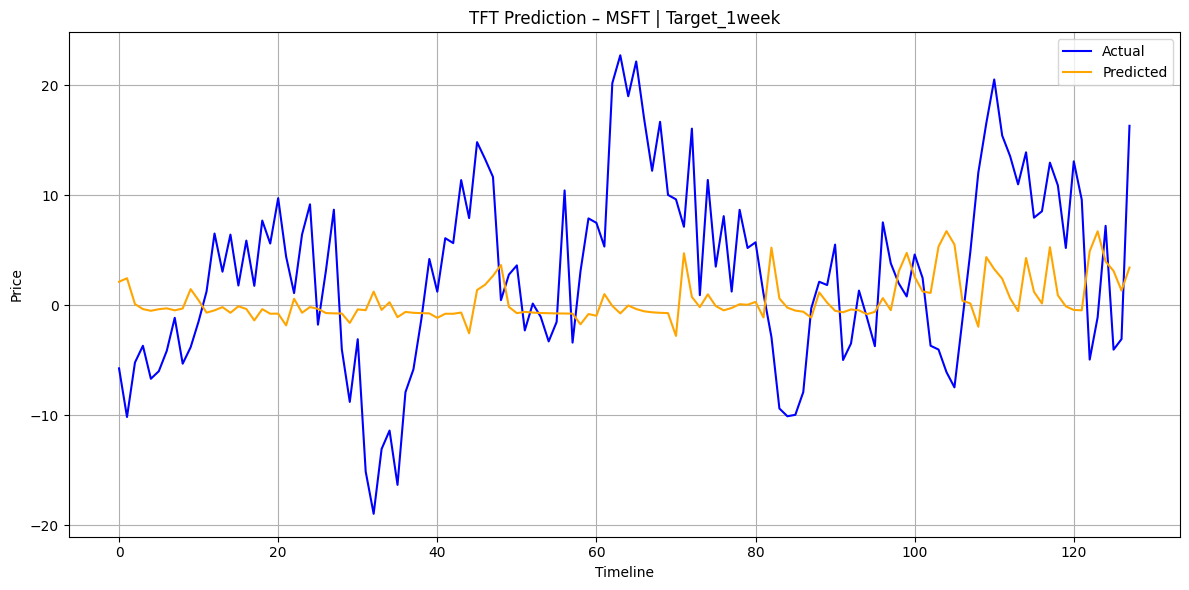

In [157]:
# Visualization with a single line for actual and predicted
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.title(f"TFT Prediction – {ticker} | {target}")
plt.xlabel('Timeline')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [158]:
# Save the plot
filename = f'msft_tft_{target}.png'
plt.savefig(filename)
plt.show()

<Figure size 640x480 with 0 Axes>